## COMP5328 - Advanced Machine Learning
## Assignment 1: Non-negative Matrix Factorization
----------------------------------------------------------------------------------------

**(Semester 2, 2025)**

In this ipython notebook, we provide some example code for assignment1.
+ Load Data.
    - ORL dataset. 
    - Extended YaleB dataset. 
    - AR dataset (**optional**).
+ Perform Evaluation. 
   - Relative Reconstruction Errors.
   - Accuracy, NMI (**optional**).

Lecturer: Tongliang Liu.

**Note: All datasets can be used only for this assignment and you are not allowed to distribute these datasets. If you want to use AR dataset, you need to apply it by yourself (we do not provide AR dataset due to the problem of license, please find more details in http://www2.ece.ohio-state.edu/~aleix/ARdatabase.html).**

## 1. Load Dataset

### 1.0 Data Folder

In [1]:
# The structure of data folder.
!ls -l data

total 0
drwxrwxrwx@ 41 ybs  staff  1312 Aug 25 16:59 CroppedYaleB
drwx------@ 44 ybs  staff  1408 Aug 24 15:37 ORL


### 1.1 Load ORL Dataset and Extended YaleB Dataset.
+ ORL dataset contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). The size of each image is 92x112 pixels, with 256 grey levels per pixel. To further reduce the computation complexity, you can resize all images to 30x37 pixels.

+ Extended YaleB dataset contains 2414 images of 38 human subjects under 9 poses and 64 illumination conditions. All images are manually aligned, cropped, and then resized to 168x192 pixels. To further reduce the computation complexity, you can resize all images to 42x48 pixels.

In [1]:
import os
import numpy as np
from PIL import Image

def load_data(root='data/CroppedYaleB', reduce=4):
    """ 
    Load ORL (or Extended YaleB) dataset to numpy array.
    
    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
        
    """ 
    images, labels = [], []

    for i, person in enumerate(sorted(os.listdir(root))):
        
        if not os.path.isdir(os.path.join(root, person)):
            continue
        
        for fname in os.listdir(os.path.join(root, person)):    
            
            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue
            
            if not fname.endswith('.pgm'):
                continue
                
            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') # grey image.

            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size])

            # TODO: preprocessing.

            # convert image to numpy array.
            img = np.asarray(img).reshape((-1,1))

            # collect data and label.
            images.append(img)
            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels

In [3]:
# Load ORL dataset.
X, Y = load_data(root='data/ORL', reduce=2)
print('ORL dataset: X.shape = {}, Y.shape = {}'.format(X.shape, Y.shape))

# Load Extended YaleB dataset.
X, Y = load_data(root='data/CroppedYaleB', reduce=4)
print('Extended YalB dataset: X.shape = {}, Y.shape = {}'.format(X.shape, Y.shape))

ORL dataset: X.shape = (2576, 400), Y.shape = (400,)
Extended YalB dataset: X.shape = (2016, 2414), Y.shape = (2414,)


In [2]:
# Load ORL dataset.
X, Y = load_data(root='data/ORL', reduce=2)
print('ORL dataset: X.shape = {}, Y.shape = {}'.format(X.shape, Y.shape))

ORL dataset: X.shape = (2576, 400), Y.shape = (400,)


### 1.2 Load AR Dataset (Optional) 
AR dataset contains 2600 images of 100 individuals (50 male and 50 female). All images have been cropped and resized to 120x165 pixels. To further reduce the computation complexity, you can resize all images to 40x55 pixels.

In [4]:
def load_data_AR(root='data/CroppedAR', reduce=3):
    """ 
    Load AR dataset to numpy array.
    
    Args:
        root: path to AR dataset.
        reduce: scale factor for zooming out images.
        
    """ 
    images, labels = [], []
    
    for fname in os.listdir(root):
        
        if not fname.endswith('.bmp'):
            continue
        
        # get label.
        label = int(fname[2:5])
        if fname[0] == 'W': # start from 50
            label += 50
        
        # load image.
        img = Image.open(os.path.join(root, fname))
        img = img.convert('L') # grey
        
        # reduce computation complexity.
        img = img.resize([s//reduce for s in img.size])
   
        # TODO: preprocessing.
        
        # convert image to numpy array.
        img = np.asarray(img).reshape((-1,1))
        
        # collect data and label.
        images.append(img)
        labels.append(label)
        
    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)
    
    return images, labels

In [5]:
# X, Y = load_data_AR(root='data/CroppedAR', reduce=3)
# print('AR dataset: X.shape = {}, Y.shape = {}'.format(X.shape, Y.shape))

---------------------------


## 2. Evaluation Metrics


### 2.1 Relative Reconstruction Errors (RRE)

To compare the robustness of different NMF algorithms, you can use the ```relative reconstruction errors```. Let $V$ denote the contaminated dataset (by adding noise), and $\hat{V}$
 denote the clean dataset. Let $W$ and $H$ denote the factorization results on $V$, the ``relative reconstruction errors`` then can be defined as follows:
 \begin{equation}
    RRE = \frac{ \| \hat{V} - WH \|_F }{ \| \hat{V} \|_F}.
\end{equation}


==> Load ORL dataset ...
V_hat.shape=(1110, 400), Y_hat.shape=(400,)


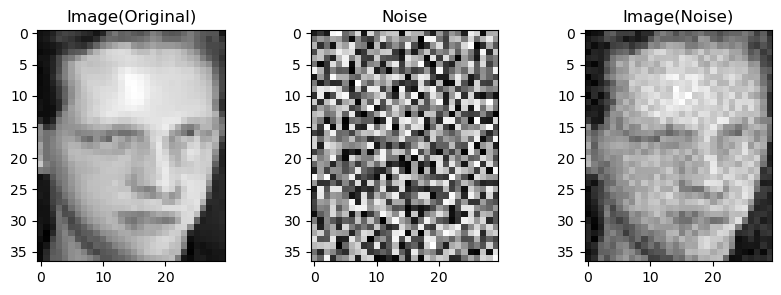

==> Apply NMF ...
W.shape=(1110, 40), H.shape=(40, 400)
==> Evaluate RRE ...
RRE = 0.3011081317886962


In [5]:
# Load dataset.
print('==> Load ORL dataset ...')
V_hat, Y_hat = load_data('data/ORL', reduce=3)
print('V_hat.shape={}, Y_hat.shape={}'.format(V_hat.shape, Y_hat.shape))

# Add Noise.
V_noise = np.random.rand(*V_hat.shape) * 40
V = V_hat + V_noise

# Plot result.
import matplotlib.pyplot as plt
img_size = [i//3 for i in (92, 112)] # ORL
ind = 1 # index of demo image.
plt.figure(figsize=(10,3))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(V_noise[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Noise')
plt.subplot(133)
plt.imshow(V[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Noise)')
plt.show()

# TODO: you should implement NMF algorithms by yourself.
print('==> Apply NMF ...')
from sklearn.decomposition import NMF
model = NMF(n_components=len(set(Y_hat))) # set n_components to num_classes.
W = model.fit_transform(V)
H = model.components_
print('W.shape={}, H.shape={}'.format(W.shape, H.shape))

# Evaluate relative reconstruction errors.
print('==> Evaluate RRE ...')
RRE = np.linalg.norm(V_hat - W.dot(H)) / np.linalg.norm(V_hat)
print('RRE = {}'.format(RRE))

In [21]:
# Multiplicative Update Rules
# Step 1. Initialize dictionary and coefficient matrices
def initialise_matrices(V, k, random_state=None):
    """
    Initialize the W (basis dictionary) and H (coefficient) matrices with random non-negative values
    
    Args:
        V: Input data matrix (m × n)
        k: Number of components 
        random_state: Random seed for reproducibility
    
    Returns:
        W: Initial basis matrix (m × k)
        H: Initial coefficient matrix (k × n)
    """
    m, n = V.shape
    
    # Initialize W and H with random positive values
    rng = np.random.RandomState(random_state)
    W = rng.rand(m, k)
    H = rng.rand(k, n)
    
    return W, H

W_init, H_init = initialise_matrices(V, k=10, random_state=42)
print(f"V shape: {V.shape}")
print(f"W shape: {W_init.shape}")
print(f"H shape: {H_init.shape}")

V shape: (1110, 400)
W shape: (1110, 10)
H shape: (10, 400)


In [28]:
# Step 2. Set update rules for W and H
def H_update(V, W, H):
    """
    Multiplicative Update Rules to solve for H by setting fixed W
    
    H_new ← H_old*(W^T*V/W^T*W*H_old) 
    
    Args:
        V: Input data matrix (m × n)
        W: Current basis matrix (m × k)
        H: Current coefficient matrix (k × n)
    
    Returns:
        H_new: Updated coefficient matrix
    """
    # Compute numerator: W^T*V
    numerator = np.dot(np.transpose(W), V)
    
    # Compute denominator: W^T*W*H_old
    denominator = np.dot(np.dot(np.transpose(W), W), H)
    
    # Multiplicative update
    H_new = H * (numerator / denominator)
    
    return H_new
    
def W_update(V, W, H):
    """
    Multiplicative Update Rules to solve for W by setting fixed H
    
    W_new ← W_old*(V*H^T/W_old*H*H^T) 
    
    Args:
        V: Input data matrix (m × n)
        W: Current basis matrix (m × k)
        H: Current coefficient matrix (k × n)
    
    Returns:
        W_new: Updated dictionary matrix
    """
    # Compute numerator: V*H^T
    numerator = np.dot(V, np.transpose(H))
    
    # Compute denominator: W_old*H*H^T
    denominator = np.dot(np.dot(W, H), np.transpose(H))
    
    # Multiplicative update
    W_new = W * (numerator / denominator)
    
    return W_new

In [25]:
# Step 3. Calculate the loss
def compute_reconstruction_error(V, W, H):
    """
    Compute the Frobenius norm reconstruction error
    
    Args:
        V: Original data matrix
        W: Basis matrix
        H: Coefficient matrix
    
    Returns:
        error: Frobenius norm of (V - WH)
    """
    reconstruction = np.dot(W, H)
    error = np.linalg.norm(V - reconstruction, 'fro')
    return error

In [26]:
# Step 4. Optimisation iteration
def optimisation(V, k, max_iter=1000, tol=1e-6, verbose=True, random_state=None):
    """
    Complete optimisation process
    
    Args:
        V: Input data matrix (m × n)
        k: Number of components
        max_iter: Maximum number of iterations
        tol: Convergence tolerance
        random_state: Random seed for initialization
    
    Returns:
        W: Basis matrix (m × k)
        H: Coefficient matrix (k × n)
        errors: List of reconstruction errors at each iteration
    """
     # Initialise matrices
    W, H = initialise_matrices(V, k, random_state)
    
    # Store errors for monitoring convergence
    errors = []
    
    # Main optimization loop
    for iteration in range(max_iter):
        # Store previous error
        prev_error = compute_reconstruction_error(V, W, H)
        errors.append(prev_error)
        
        # Update H
        H = H_update(V, W, H)

        # Update W
        W = W_update(V, W, H)
        
        # Compute new error
        current_error = compute_reconstruction_error(V, W, H)
        
        # Check convergence
        if abs(prev_error - current_error) < tol:
            if verbose:
                print(f"Converged at iteration {iteration+1}")
            break
        
        # Print progress every 100 iterations
        if verbose and (iteration + 1) % 100 == 0:
            print(f"Iteration {iteration+1}: Error = {current_error:.6f}")
    
    # Add final error
    errors.append(compute_reconstruction_error(V, W, H))
    
    return W, H, errors
    

In [37]:
# Step 5. Applying NMF
print('==> Apply NMF ...')
W_final, H_final, error_final = optimisation(V, k=40, max_iter=1000, tol=1e-6, verbose=True, random_state=42)
print('W.shape={}, H.shape={}, final error={}'.format(W_final.shape, H_final.shape, error_final[len(error_final)-1]))

# Evaluate relative reconstruction errors.
print('==> Evaluate RRE ...')
RRE_final = np.linalg.norm(V_hat - np.dot(W_final, H_final)) / np.linalg.norm(V_hat)
print('RRE = {}'.format(RRE_final))

==> Apply NMF ...
Iteration 100: Error = 15327.111283
Iteration 200: Error = 13548.907350
Iteration 300: Error = 13011.033794
Iteration 400: Error = 12780.820365
Iteration 500: Error = 12661.606615
Iteration 600: Error = 12590.698192
Iteration 700: Error = 12543.551719
Iteration 800: Error = 12509.609384
Iteration 900: Error = 12483.631985
Iteration 1000: Error = 12462.932815
W.shape=(1110, 40), H.shape=(40, 400), final error=12462.93281502906
==> Evaluate RRE ...
RRE = 0.20876505990456806


In [38]:
# Step 6. Comparing the results with NMF by sklearn
print('==> Apply NMF with sklearn ...')
from sklearn.decomposition import NMF
model = NMF(n_components=len(set(Y_hat))) # set n_components to num_classes.
W_sklearn = model.fit_transform(V)
H_sklearn = model.components_
print('W.shape={}, H.shape={}'.format(W_sklearn.shape, H_sklearn.shape))

# Evaluate relative reconstruction errors.
print('==> Evaluate RRE ...')
RRE_sklearn = np.linalg.norm(V_hat - W_sklearn.dot(H_sklearn)) / np.linalg.norm(V_hat)
print('RRE = {}'.format(RRE_sklearn))

print(f"\nComparison:")
print(f"Our RRE:     {RRE_final:.6f}")
print(f"Sklearn RRE: {RRE_sklearn:.6f}")
print(f"Difference:  {abs(RRE_final - RRE_sklearn):.6f}")

==> Apply NMF with sklearn ...
W.shape=(1110, 40), H.shape=(40, 400)
==> Evaluate RRE ...
RRE = 0.30201221494080804

Comparison:
Our RRE:     0.208765
Sklearn RRE: 0.302012
Difference:  0.093247


### 2.2 Evaluate Clustering Performance

1. Accuracy.
    
    $$ Acc(Y, Y_{pred}) = \frac{1}{n}\sum\limits_{i=1}^n 1\{Y_{pred}(i) == Y(i)\}$$
        
2. Normalized Mutual Information (NMI).

    $$ NMI(Y, Y_{pred}) = \frac{2 * I(Y, Y_{pred})}{H(Y) + H(Y_{pred})} $$
    
   where $ I(\cdot,\cdot) $ is mutual information and $ H(\cdot) $ is entropy.

In [7]:
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

def assign_cluster_label(X, Y):
    kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
    return Y_pred

print('==> Evaluate Acc and NMI ...')

# Assign cluster labels.
Y_pred = assign_cluster_label(H.T, Y_hat)

acc = accuracy_score(Y_hat, Y_pred)
nmi = normalized_mutual_info_score(Y_hat, Y_pred)
print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))


==> Evaluate Acc and NMI ...
Acc(NMI) = 0.5875 (0.7431)


In [ ]:
# Step 6: Test clustering performance with our NMF
def test_clustering_with_our_nmf(V_hat, Y_hat, noise_levels=[10, 20, 40, 60]):
    """Test clustering performance using our NMF implementation"""
    from sklearn.cluster import KMeans
    from sklearn.metrics import accuracy_score, normalized_mutual_info_score
    
    results = []
    
    for noise_level in noise_levels:
        print(f"\nTesting with noise level: {noise_level}")
        
        # Add noise with fixed random state for reproducibility
        np.random.seed(42)  # Same seed for consistent noise across tests
        V_noise = np.random.rand(*V_hat.shape) * noise_level
        V = V_hat + V_noise
        
        # Apply our NMF
        W, H, errors = nmf_multiplicative_update(
            V, n_components=len(set(Y_hat)), max_iter=200, 
            random_state=42, verbose=False
        )
        
        # Test clustering on H (coefficient matrix)
        def assign_cluster_label(X, Y):
            kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
            Y_pred = np.zeros(Y.shape)
            for i in set(kmeans.labels_):
                ind = kmeans.labels_ == i
                Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0]
            return Y_pred
        
        Y_pred = assign_cluster_label(H.T, Y_hat)
        acc = accuracy_score(Y_hat, Y_pred)
        nmi = normalized_mutual_info_score(Y_hat, Y_pred)
        
        # Calculate RRE
        RRE = np.linalg.norm(V_hat - W @ H) / np.linalg.norm(V_hat)
        
        results.append({
            'noise_level': noise_level,
            'accuracy': acc,
            'nmi': nmi,
            'RRE': RRE
        })
        
        print(f"  Accuracy: {acc:.4f}")
        print(f"  NMI: {nmi:.4f}")
        print(f"  RRE: {RRE:.4f}")
    
    return results

# Test clustering performance
print("=== Testing Clustering Performance with Our NMF ===")
clustering_results_our = test_clustering_with_our_nmf(V_hat, Y_hat)

# Plot results
noise_levels = [r['noise_level'] for r in clustering_results_our]
acc_values = [r['accuracy'] for r in clustering_results_our]
nmi_values = [r['nmi'] for r in clustering_results_our]
rre_values = [r['RRE'] for r in clustering_results_our]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy plot
axes[0].plot(noise_levels, acc_values, 'ro-', linewidth=2, markersize=8)
axes[0].set_xlabel('Noise Level')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Clustering Accuracy vs Noise')
axes[0].grid(True, alpha=0.3)

# NMI plot
axes[1].plot(noise_levels, nmi_values, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Noise Level')
axes[1].set_ylabel('NMI')
axes[1].set_title('NMI vs Noise')
axes[1].grid(True, alpha=0.3)

# RRE plot
axes[2].plot(noise_levels, rre_values, 'bo-', linewidth=2, markersize=8)
axes[2].set_xlabel('Noise Level')
axes[2].set_ylabel('RRE')
axes[2].set_title('RRE vs Noise')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
